Import necessary packages: 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import textwrap

from os import listdir
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from statannot import add_stat_annotation
from statsmodels.stats.multitest import multipletests

from functions_rw import calc_D0, calc_D1, calc_D2
from functions_rw import concat_df
from functions_rw import get_gmm_fitted, get_fcfp_gmm_rw
from functions_rw import transform

Initialize a number of variables: 

In [2]:
np.random.seed(2703)
N_REP = 6
N_CELLS_REP = 48
N_CELLS_I = 100000
N_MIX = 400
FEATURES = ['FL1-H','FL3-H','FSC-H','SSC-H'] 
PATH_DATA = 'QC_flowAI_CSV/'
FILENAMES = sorted(listdir(PATH_DATA))
TYPE = 'full'

Read-in metadata and annotate labels ('CD' = 1 vs 'HC' = 0): 

In [3]:
target = pd.read_csv('Metadata_DC.csv', index_col=0, header=0)
label_y = 'Health status'
le = LabelEncoder()
target.loc[:,label_y] = le.fit_transform(target.loc[:,label_y])
target.loc[:,label_y] = target.loc[:,label_y].replace({0:1, 1:0})
index_healthy = target.loc[target.loc[:,label_y] == 0].index
index_cd = target.loc[target.loc[:,label_y] == 1].index

Read in genus-table and calculate relative abundances: 

In [4]:
genus_table = pd.read_table('OTU_tables/GenusAbundance_DiseaseCohort_nature24460.txt', index_col=0, header=0)
genus_comp = genus_table.div(genus_table.sum(axis=1), axis=0)
genus_comp = genus_comp.loc[target.index,:]

Calculate the genotypic diversity using Hill Diversity indices $D_0$, $D_1$ and $D_2$ ($D_0$ and $D_2$ reported in manuscript): 

In [5]:
D0_16S = calc_D0(genus_comp)
D1_16S = calc_D1(genus_comp)
D2_16S = calc_D2(genus_comp) 

Read-in flow cytometry data, concatenate all samples and transform by $f(x) = \text{asinh}(x)$: 

In [6]:
df_fcm = concat_df(target, N_CELLS_REP, PATH_DATA, FILENAMES)
df_fcm_trans = transform(df_fcm, FEATURES)

Fit a Gaussian Mixture Model (GMM) to the data and extract a fingerprint per sample: 

In [7]:
GMM = get_gmm_fitted(df_fcm_trans, FEATURES, N_MIX, TYPE, False)
fcfp = get_fcfp_gmm_rw(target, N_REP, N_CELLS_I, N_MIX, FEATURES, GMM, True, PATH_DATA, FILENAMES)

Calculate the cytometric or phenotypic diversity using Hill Diversity indices $D_0$, $D_1$ and $D_2$ ($D_0$ and $D_2$ reported in manuscript): 

In [8]:
D0_fcfp = calc_D0(fcfp)
D1_fcfp = calc_D1(fcfp)
D2_fcfp = calc_D2(fcfp)

Calculate the spearman correlation $\rho_S$ between the cytometric and genotypic diversity: 

In [9]:
r_s_D0, p_s_D0 = stats.spearmanr(D0_fcfp,D0_16S.loc[D0_fcfp.index])
r_s_D1, p_s_D1 = stats.spearmanr(D1_fcfp,D1_16S.loc[D1_fcfp.index])
r_s_D2, p_s_D2 = stats.spearmanr(D2_fcfp,D2_16S.loc[D2_fcfp.index]) 

print('r_S(D_0) = ' + str(r_s_D0) + r', P-value = ' + str(p_s_D0))
print('r_S(D_1) = ' + str(r_s_D1) + r', P-value = ' + str(p_s_D1))
print('r_S(D_2) = ' + str(r_s_D2) + r', P-value = ' + str(p_s_D2))

r_S(D_0) = 0.298240401527, P-value = 0.0033298769001
r_S(D_1) = 0.299734042553, P-value = 0.00316812717464
r_S(D_2) = 0.306354983203, P-value = 0.00253273089276


Combine results into one dataframe: 

In [10]:
target.loc[:,label_y] = target.loc[:,label_y].replace({0:1, 1:0})
target.loc[:,'Health status'] = le.inverse_transform(target.loc[:,'Health status'])
target.replace('Healthy','HC',inplace=True)
results_DIV_FCM = pd.DataFrame({r'$D_0$': D0_fcfp.loc[:,r'$D_0$'], r'$D_2$': D2_fcfp.loc[:,r'$D_2$'], 'Status': target.loc[D0_fcfp.index,'Health status'].values}, index=D0_fcfp.index)#,   
results_DIV_FCM_melt = pd.melt(results_DIV_FCM,id_vars=['Status'], value_vars=[r'$D_0$',r'$D_2$'], var_name = 'Hill number', value_name='Diversity')
results_DIV_16S = pd.DataFrame({r'$D_0$': D0_16S.loc[:,r'$D_0$'], r'$D_2$': D2_16S.loc[:,r'$D_2$'], 'Status': target.loc[D0_16S.index,'Health status'].values}, index=D0_16S.index)
results_DIV_16S_melt = pd.melt(results_DIV_16S,id_vars=['Status'], value_vars=[r'$D_0$',r'$D_2$'], var_name = 'Hill number', value_name='Diversity')
results_DIV = pd.concat([results_DIV_FCM_melt,results_DIV_16S_melt], axis=0, ignore_index=False)

Perform Mann-Whitney-U test to test whether diversity estimates for 'CD' and 'HC' belong to the same population: 

In [11]:
#For genotypic diversity estimations: 
mwu_d0_16s, p_d0_16s = stats.mannwhitneyu(D0_16S.loc[index_healthy],D0_16S.loc[index_cd])
mwu_d1_16s, p_d1_16s = stats.mannwhitneyu(D1_16S.loc[index_healthy],D1_16S.loc[index_cd])
mwu_d2_16s, p_d2_16s = stats.mannwhitneyu(D2_16S.loc[index_healthy],D2_16S.loc[index_cd])

print('U(D_0) = ' + str(mwu_d0_16s) + r', P-value = ' + str(p_d0_16s))
print('U(D_1) = ' + str(mwu_d1_16s) + r', P-value = ' + str(p_d1_16s))
print('U(D_2) = ' + str(mwu_d2_16s) + r', P-value = ' + str(p_d2_16s))

U(D_0) = 372.0, P-value = 1.14848515173e-06
U(D_1) = 269.0, P-value = 1.38068996439e-08
U(D_2) = 305.0, P-value = 7.00942887649e-08


In [12]:
#For cytometric diversity estimations: 
mwu_d0_fcm, p_d0_fcm = stats.mannwhitneyu(D0_fcfp.loc[index_healthy],D0_fcfp.loc[index_cd])
mwu_d1_fcm, p_d1_fcm = stats.mannwhitneyu(D1_fcfp.loc[index_healthy],D1_fcfp.loc[index_cd])
mwu_d2_fcm, p_d2_fcm = stats.mannwhitneyu(D2_fcfp.loc[index_healthy],D2_fcfp.loc[index_cd])

print('U(D_0) = ' + str(mwu_d0_fcm) + r', P-value = ' + str(p_d0_fcm))
print('U(D_1) = ' + str(mwu_d1_fcm) + r', P-value = ' + str(p_d1_fcm))
print('U(D_2) = ' + str(mwu_d2_fcm) + r', P-value = ' + str(p_d2_fcm))

U(D_0) = 447.5, P-value = 1.92642180871e-05
U(D_1) = 350.0, P-value = 4.75925367483e-07
U(D_2) = 314.0, P-value = 1.03873356924e-07


Plot results: 

['CD', 'HC']


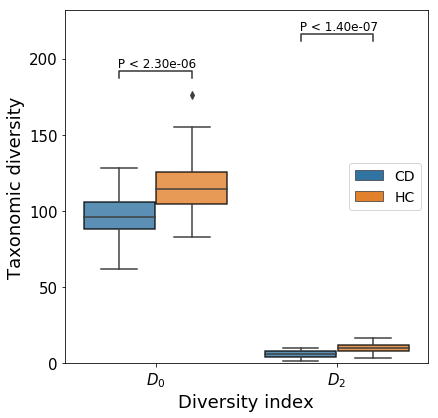

In [13]:
#For taxonomic diversity estimations (Fig. 2A): 
plt.figure(figsize=(6.5,6.5))
g = sns.boxplot(x='Hill number', y='Diversity', hue='Status', data=results_DIV_16S_melt)#, kind='box')
g.set(ylim=(0.0, 225))
add_stat_annotation(g, data=results_DIV_16S_melt, x='Hill number', y='Diversity', hue='Status',
                    boxPairList=[((r'$D_0$', 'CD'), (r'$D_0$', 'HC')),((r'$D_2$', 'CD'), (r'$D_2$', 'HC'))],
                    test='Mann-Whitney', textFormat='full', loc='inside', verbose=1, fontsize=12)
plt.setp(g.artists, alpha=.8, linewidth=1.5, fill=True, edgecolor="k")
g.set_xlabel('Diversity index', size=18)
g.set_ylabel('Taxonomic diversity', size=18)
g.set_xticklabels([textwrap.fill(t.get_text(), 10)  for t in g.get_xticklabels()],size=15)
g.set_yticklabels([textwrap.fill(t.get_text(), 10)  for t in g.get_yticklabels()],size=15)
plt.legend(loc='center right', fontsize=14)
plt.savefig('Figures/Fig2A_a_div_16S.png', bbox_tight=True, dpi=500)

['CD', 'HC']


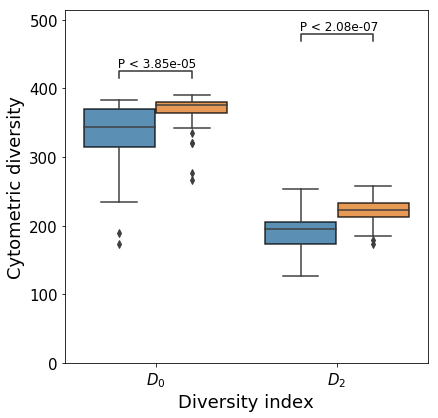

In [14]:
#For cytometric diversity estimations (Fig. 2B): 
plt.figure(figsize=(6.5,6.5))
g = sns.boxplot(x='Hill number', y='Diversity', hue='Status', data=results_DIV_FCM_melt)#, kind='box')
g.set(ylim=(0.0, 500))
add_stat_annotation(g, data=results_DIV_FCM_melt, x='Hill number', y='Diversity', hue='Status',
                    boxPairList=[((r'$D_0$', 'CD'), (r'$D_0$', 'HC')),((r'$D_2$', 'CD'), (r'$D_2$', 'HC'))],
                    test='Mann-Whitney', textFormat='full', loc='inside', verbose=1, fontsize=12)
plt.setp(g.artists, alpha=.8, linewidth=1.5, fill=True, edgecolor="k")
g.set_xlabel('Diversity index', size=18)
g.set_ylabel('Cytometric diversity', size=18)
g.set_xticklabels([textwrap.fill(t.get_text(), 10)  for t in g.get_xticklabels()],size=15)
g.set_yticklabels([textwrap.fill(t.get_text(), 10)  for t in g.get_yticklabels()],size=15)
g.get_legend().remove()
plt.savefig('Figures/Fig2B_a_div_FCM.png', bbox_tight=True, dpi=500)
plt.show()

Determine which mixtures that are significant markers for 'CD' vs. 'HC' with FDR corrected multiple hypothesis testing: 

In [15]:
mwu_mixtures = np.zeros(N_MIX)
p_vals_mixtures = np.zeros(N_MIX)
bool_cd_lower_hc = np.zeros(N_MIX)
for i in np.arange(0,N_MIX): 
    mwu_mixtures[i], p_vals_mixtures[i] = stats.mannwhitneyu(fcfp.loc[index_healthy,i],fcfp.loc[index_cd,i])
    if fcfp.loc[index_healthy,i].median() > fcfp.loc[index_cd,i].median(): 
        bool_cd_lower_hc[i] = 1
        
q = multipletests(p_vals_mixtures, alpha=0.05, method='fdr_bh')
bool_q_vals = pd.DataFrame(q[0])
q_vals = pd.DataFrame(q[1])
fcfp.loc[target.index,'Health status'] = target.loc[:,'Health status']

Plot means of mixtures in function of level of significance: 

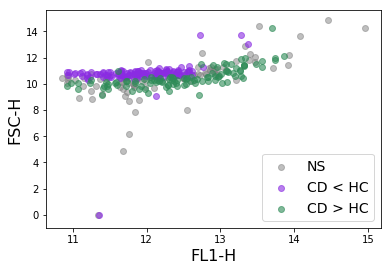

In [16]:
booleans = pd.concat([bool_q_vals,pd.DataFrame(bool_cd_lower_hc)], axis=1)
means_gmm = pd.DataFrame(GMM.means_)
means_gmm['Significant'] = bool_q_vals
means_gmm['CD < HC'] = bool_cd_lower_hc

plt.scatter(means_gmm[(means_gmm['Significant'] == 0) & (means_gmm['CD < HC'] == 0)].loc[:,0],means_gmm[(means_gmm['Significant'] == 0) & (means_gmm['CD < HC'] == 0)].loc[:,2], c='gray', alpha=0.5)
plt.scatter(means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 1)].loc[:,0],means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 1)].loc[:,2], c='blueviolet', alpha=0.6)
plt.scatter(means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 0)].loc[:,0],means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 0)].loc[:,2], c='seagreen', alpha=0.6)
plt.xlabel('FL1-H', size=16)
plt.ylabel('FSC-H', size=16)
plt.legend(['NS','CD < HC', 'CD > HC'], fontsize=14)
plt.savefig('Figures/Fig2C_FSC_FL1_CD_vs_HC.png', dpi=300, bbox_tight=True)

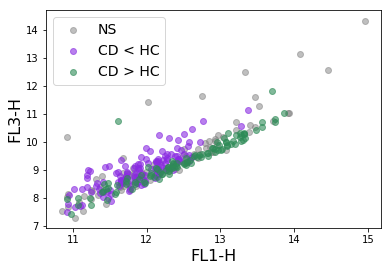

In [17]:
plt.scatter(means_gmm[(means_gmm['Significant'] == 0) & (means_gmm['CD < HC'] == 0)].loc[:,0],means_gmm[(means_gmm['Significant'] == 0) & (means_gmm['CD < HC'] == 0)].loc[:,1], c='gray', alpha=0.5)
plt.scatter(means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 1)].loc[:,0],means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 1)].loc[:,1], c='blueviolet', alpha=0.6)
plt.scatter(means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 0)].loc[:,0],means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 0)].loc[:,1], c='seagreen', alpha=0.6)
plt.xlabel('FL1-H', size=16)
plt.ylabel('FL3-H', size=16)
plt.legend(['NS','CD < HC', 'CD > HC'], fontsize=14)

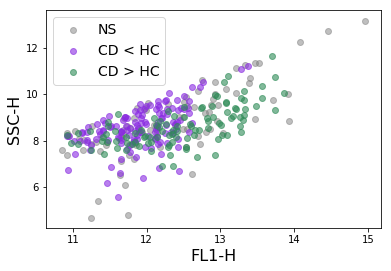

In [18]:
plt.scatter(means_gmm[(means_gmm['Significant'] == 0) & (means_gmm['CD < HC'] == 0)].loc[:,0],means_gmm[(means_gmm['Significant'] == 0) & (means_gmm['CD < HC'] == 0)].loc[:,3], c='gray', alpha=0.5)
plt.scatter(means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 1)].loc[:,0],means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 1)].loc[:,3], c='blueviolet', alpha=0.6)
plt.scatter(means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 0)].loc[:,0],means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 0)].loc[:,3], c='seagreen', alpha=0.6)
plt.xlabel('FL1-H', size=16)
plt.ylabel('SSC-H', size=16)
plt.legend(['NS','CD < HC', 'CD > HC'], fontsize=14)

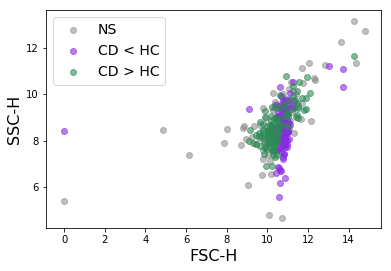

In [19]:
plt.scatter(means_gmm[(means_gmm['Significant'] == 0) & (means_gmm['CD < HC'] == 0)].loc[:,2],means_gmm[(means_gmm['Significant'] == 0) & (means_gmm['CD < HC'] == 0)].loc[:,3], c='gray', alpha=0.5)
plt.scatter(means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 1)].loc[:,2],means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 1)].loc[:,3], c='blueviolet', alpha=0.6)
plt.scatter(means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 0)].loc[:,2],means_gmm[(means_gmm['Significant'] == 1) & (means_gmm['CD < HC'] == 0)].loc[:,3], c='seagreen', alpha=0.6)
plt.xlabel('FSC-H', size=16)
plt.ylabel('SSC-H', size=16)
plt.legend(['NS','CD < HC', 'CD > HC'], fontsize=14)